In [1]:
from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

import heapq

from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import random
import itertools

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import time

In [2]:

# Definición de la clase ShepherdAgent, que hereda de Agent.
class HunterAgent(Agent):
    def __init__(self, id, model, initial_pos):
        super().__init__(id, model)  # Llamamos al constructor de la clase base.
        self.id = id  # Asignamos el ID del agente.
        self.holdingSurvivor = False  # Indicador de si el agente está cargando una oveja.
        self.AP = 0  # Indicador de si el agente está cargando una oveja.
        self.passTurn= False
        self.action_history = []
        self.spawn = initial_pos
    def heuristic(self, cell, goal):
    # Manhattan distance (L1 distance)
      return abs(cell[0] - goal[0]) + abs(cell[1] - goal[1])

    def a_star(self, grid, ag, goals):
      open_list = [(0, ag)]  # priority queue
      closed_list = set()
      came_from = {}
      cost_so_far = {ag: 0}

      if len(goals) >= 1:
          while open_list:
              _, current = heapq.heappop(open_list)
              if current in goals:
                  path = []
                  while current in came_from:
                      path.append(current)
                      current = came_from[current]
                  return path[::-1]

              closed_list.add(current)
              for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:  # 4-neighbors
                  x, y = current[0] + dx, current[1] + dy
                  neighbor = (x, y)
                  if neighbor not in grid:
                      continue
                  if neighbor in closed_list:
                      continue
                  cost = grid[neighbor]
                  tentative_cost = cost_so_far[current] + cost

                  if neighbor not in cost_so_far or tentative_cost < cost_so_far[neighbor]:
                      cost_so_far[neighbor] = tentative_cost

                      # Verificar si hay un objetivo válido
                      valid_goals = [self.heuristic(neighbor, goal) for goal in goals if goals[goal]]

                      if valid_goals:
                          priority = tentative_cost + min(valid_goals)
                      else:
                          # Si no hay objetivos válidos, usar la ubicación del agente
                          priority = tentative_cost + self.heuristic(neighbor, ag)

                      heapq.heappush(open_list, (priority, neighbor))
                      came_from[neighbor] = current
          return [ag]  # no path found
      else:
          return [ag]

    def move(self):
        # Obtén las celdas vecinas
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        #path = self.a_star(self.model.grid_values, self.pos, self.model.interestPoints)
        # Si hay celdas vecinas
        if self.holdingSurvivor==True:
          diccionary= {self.spawn: False}
          path = self.a_star(self.model.grid_values, self.pos, diccionary)
        else:
          path = self.a_star(self.model.grid_values, self.pos, self.model.interestPoints)
        if path:
          new_position = path[0]
          if self.colission(self.pos, new_position):
            new_position = random.choice(neighbors)
        else:
          new_position = random.choice(neighbors)
        if neighbors:
            # Disminuye los puntos de acción según las condiciones
            move_to_Fire = self.model.grid_values[new_position] == 2  # Ajusta según la lógica de tu modelo
            move_to_non_Fire = self.model.grid_values[new_position] != 2  # Ajusta según la lógica de tu modelo
            carry_victim = False  # Ajusta según la lógica de tu modelo
            #position_grid= (self.pos[0]+1, self.pos[1]+1)
            #position_grid2= (new_position[0]+1, new_position[1]+1)
            if self.pos in self.model.doors and new_position in self.model.doors and self.AP>=1:
              if self.model.doors[self.pos]==False and self.model.doors[new_position]==False:
                self.open_door(self.pos, new_position)
            if not self.colission(self.pos, new_position):
              if move_to_Fire and self.AP>=2:
                # Mueve al agente a la nueva posición
                self.model.grid.move_agent(self, new_position)
                #Lo registra en el historial
                self.action_history.append(f"moved:{new_position}")
                self.AP -= 2
              elif move_to_non_Fire and self.AP >= 1:
                # Mueve al agente a la nueva posición
                self.model.grid.move_agent(self, new_position)
                #Lo registra en el historial
                self.action_history.append(f"moved:{new_position}")
                self.AP -= 1
              elif carry_victim and self.AP >= 2:
                # Mueve al agente a la nueva posición
                self.model.grid.move_agent(self, new_position)
                #Lo registra en el historial
                self.action_history.append(f"moved:{new_position}")
                self.AP -= 2
            self.flipPOI()
    def flipPOI(self):
      if self.pos in self.model.interestPoints:
        if self.model.interestPoints[self.pos] == True:
          self.holdingSurvivor = True
          #self.model.rescued +=1
        del self.model.interestPoints[self.pos]  # Elimina el punto de interés
        self.action_history.append(f"flipPOI{self.pos}")
    def nextTurn(self):
      self.action_history.append(f"passTurn")
      self.passTurn= True
    def open_door(self,coord1, coord2):
      if coord1 in self.model.doors and coord2 in self.model.doors:
          self.model.doors[coord1] = True
          self.model.doors[coord2] = True
          self.action_history.append(f"open door:{coord1}-{coord2}")
          self.AP -= 1
    def close_door(self,coord1, coord2):
      if coord1 in self.model.doors and coord2 in self.model.doors:
          self.model.doors[coord1] = False
          self.model.doors[coord2] = False
          self.AP -= 1
    def extinguish(self):
        # Obtén las celdas vecinas
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        # Busca celdas vecinas con fuego (valor de 1 en grid_values)
        fire_cells = [cell for cell in neighbors if self.model.grid_values[cell] == 2]
        smoke_cells = [cell for cell in neighbors if self.model.grid_values[cell] == 1]

        if fire_cells  and self.AP >=2:
            # Elige una celda con fuego al azar para extinguir
            cell_to_extinguish = random.choice(fire_cells)
            # Extingue el fuego (cambia el valor de la celda a 0)
            self.AP -= 2
            self.model.grid_values[cell_to_extinguish]= 0
            self.action_history.append(f"extinguished:{cell_to_extinguish}")
        elif smoke_cells  and self.AP >=1:
          # Elige una celda con fuego al azar para extinguir
            cell_to_extinguish = random.choice(smoke_cells)
            # Extingue el fuego (cambia el valor de la celda a 0)
            self.AP -= 1
            self.model.grid_values[cell_to_extinguish]= 0
            self.action_history.append(f"extinguished:{cell_to_extinguish}")
        else:
          pass
    def chop(self):
      chop_wall= False
      self.AP -= 2
    def colission(self, origin, next_position):
      x= next_position[0] - origin[0]
      y= next_position[1] - origin[1]
      direction=None
      #Se comprueba la direccion de movimiento
      if x == 0:
        if y<0:
          direction= 0
        else:
          direction= 2
      elif y == 0:
        if x<0:
          direction= 1
        else:
          direction= 3
      else:
        pass
      #Se verifica si hay un muro en esa direccion
      wallCheck= direction != None and self.model.grid_walls[origin][0][direction] == "1"
      #doorCheck= origin in self.model.doors and next_position in self.model.doors and self.model.doors[origin]==True and self.model.doors[next_position]==True
      if origin in self.model.doors and next_position in self.model.doors:
        doorCheck = self.model.doors[origin]==False and self.model.doors[next_position] == False
      else:
        doorCheck = True # Assume no doaor if key not in dictionary
      colissionCheck= wallCheck and doorCheck
      #print("Verificacion entre celda ", origin, ": ",self.model.grid_walls[origin], "y celda ", next_position, ": ",self.model.grid_walls[next_position], "Resultado: ", colissionCheck)
      return colissionCheck
    def action(self):
      #options = [self.move, self.nextTurn, self.openClose, self.extinguish,self.chop]
      if self.pos == self.spawn and self.holdingSurvivor==True:
        self.model.rescued +=1
        self.holdingSurvivor= False
      #options = [self.move, self.extinguish, self.nextTurn]  # Initialize an empty list to store the action history
      options = [self.move, self.extinguish]
      random.shuffle(options)
      while self.passTurn==False and self.AP >= 0:
          actionMade = random.choice(options)
          #self.action_history.append(actionMade.__name__)  # Append the action name to the history list
          actionMade()
          if self.AP <= 0:
                self.nextTurn()
      self.action_history.append(f"Count:{self.AP} AP")
    # Método que define el comportamiento del agente en cada paso de la simulación.
    def step(self):
      self.passTurn= False
      self.action_history = []
      self.AP += 4
      if self.AP > 8:
        self.AP = 8
      self.action()
# Función para obtener la representación de la cuadrícula en un momento dado.

In [3]:
def get_grid(model):
    grid = []
    for y in range(model.grid.height):
        row = []
        for x in range(model.grid.width):
            if model.grid.is_cell_empty((x, y)) == False:
                row.append(3)  # Representa la posición de un agente.
            elif (x, y) in model.interestPoints:
                row.append(4)  # Representa un punto de interés.
            elif model.grid_values[(x, y)] == 1:
                row.append(1)  # Representa un valor 1 en grid_values.
            elif model.grid_values[(x, y)] == 2:
                row.append(2)  # Representa un valor 2 en grid_values.
            else:
                row.append(0)  # Celda vacía.
        grid.append(row)
    return grid


In [4]:
def get_walls(model):
    grid = []
    for y in range(model.grid.height):
        row = []
        for x in range(model.grid.width):
          row.append(model.grid_walls[(x, y)][0])
        grid.append(row)
    return grid

In [5]:
# Definición de la clase ShepherdModel, que hereda de Model.
class GhostModel(Model):
    def __init__(self, num_agents, i_points, walls, doors, fire, entry):
        super().__init__()
        self.steps = 0  # Contador de pasos.
        self.schedule = SimultaneousActivation(self)  # Programador de activación simultánea de agentes.
        self.rescued= 0
        self.losses= 0
        self.status = "In progress"
        self.fire = [(int(y) -1, int(x) -1) for x, y in (coordenada.split() for coordenada in fire)]
        self.initialConfig = [elemento.split() for elemento in walls]
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid,"Walls": get_walls, "Steps": "steps", "Doors": "doors", "InterestPoints": "interestPoints", "Rescued": "rescued", "Status": "status", "Fatalities": "losses", "Damage": "damageMarker"}, agent_reporters={
        "Agent_ID": lambda agent: agent.id,
        "Position": lambda agent: (agent.pos[0], agent.pos[1]),
        "Action_History": lambda agent: agent.action_history
    })
        self.interestPoints = {(int(y) -1, int(x) -1): value for (x, y), value in i_points.items()}
        # Dimensiones del grid
        self.width = 8
        self.height = 6
        self.doors = doors
        self.entry= [(int(y) -1, int(x) -1) for x, y in (coordenada.split() for coordenada in entry)]
        self.grid = MultiGrid(self.width, self.height, torus=False)  # Creación de la cuadrícula con agentes.
        self.grid_values = {(x, y): 0 for y in range(self.height) for x in range(self.width)}  # Cuadricula con las piezas del juego.
        self.grid_walls = {(x, y): ["0000", "0000"] for y in range(self.height) for x in range(self.width)}  # Cuadricula con las piezas del juego.
        self.damageMarker= 0
        #Creacion de configuracion inicial de los muros
        for y, row in enumerate(self.initialConfig):
          for x, value in enumerate(row):
              self.grid_walls[(x, y)] = [value, "0000"]

        #Se inicializa el fuego en el campo
        for pos in self.fire:
            self.grid_values[pos] = 2
        #Se inicializan los puntos de interes
        for key, value in self.interestPoints.items():
          pass
          #self.grid_values[key] = 3
        # Inicializamos los agentes.
        entry_cycle = itertools.cycle(self.entry)
        for i in range(num_agents):
          p = next(entry_cycle)
          agent = HunterAgent(i, self, p)
          self.grid.place_agent(agent, p)
          self.schedule.add(agent)  # Añadimos el agente al programador
    def replenishPOI(self):
      current_points = len(self.interestPoints)
      # Solo agregar puntos si hay menos de 3
      if current_points < 3:
          points_to_add = 3 - current_points
          added_points = 0

          while added_points < points_to_add:
              # Seleccionar una posición al azar
              new_point = (random.randint(0, self.width - 1), random.randint(0, self.height - 1))
               # Verificar si ya hay un punto de interés en la posición seleccionada
              if new_point not in self.interestPoints:
                  # Añadir el nuevo punto de interés
                  self.interestPoints[new_point] = True
                  self.grid_values[new_point] = 0
                  added_points += 1
              # Verificar si hay un agente en la posición seleccionada
              else:
                agents_in_cell = self.grid.get_cell_list_contents([new_point])
                for agent in agents_in_cell:
                    if isinstance(agent, HunterAgent):
                        agent.flipPOI()
                        break

    def advanceFire(self):
      positions = [pos for pos, value in self.grid_values.items() if value in (0, 1, 2)]
      if positions:
        # Seleccionar una posición al azar
        new_fire_position = random.choice(positions)
        # Aparece el humo
        if self.grid_values[new_fire_position]==0:
          self.grid_values[new_fire_position] = 1
        #Convierte el humo en fuego
        elif self.grid_values[new_fire_position]==1:
          self.grid_values[new_fire_position] = 2
        #Crea explosiones si es que ya hay fuego en la casilla seleccionada
        elif self.grid_values[new_fire_position]==2:
          neighbors = self.grid.get_neighborhood(new_fire_position, moore=False, include_center=False)
          # Propaga el fuego a las celdas adyacentes
          for neighbor in neighbors:
            if self.collission(new_fire_position, neighbor):
                self.damage(new_fire_position, neighbor)
                #print("Explosion detenida en celda: ", new_fire_position, "y celda: ",neighbor)
            if self.grid_values[neighbor] == 0:  # Si la celda adyacente es espacio abierto
              self.grid_values[neighbor] = 2  # Se convierte en fuego
            elif self.grid_values[neighbor] == 1:  # Si la celda adyacente tiene humo
              self.grid_values[neighbor] = 2  # Se convierte en fuego
            elif self.grid_values[neighbor] == 2: # Si la celda adyacente tiene fuego
              self.shockWave(neighbor) #Se crea una onda de choque(implementado pero no probado)
    def damage(self, origin, stop):
      if origin in self.doors and stop in self.doors:
        if self.doors[origin]==False and self.doors[stop]==False:
          del self.doors[origin]
          del self.doors[stop]
          origin_wall = list(self.grid_walls[origin][0])
          stop_wall = list(self.grid_walls[stop][0])


          directionOrigin= self.getDirection(origin, stop)
          directionStop= self.getDirection(stop, origin)

          origin_wall = list(self.grid_walls[origin][0])
          stop_wall = list(self.grid_walls[stop][0])

          origin_wall[directionOrigin]= "0"
          stop_wall[directionStop]= "0"

          #print("Destruccion muro: ", origin,"-",stop)
          #print("walls: ", self.grid_walls[origin][0], " - ", self.grid_walls[stop][0])
          # Convert the lists back to strings for storage
          self.grid_walls[origin][0] = ''.join(origin_wall)
          self.grid_walls[stop][0] = ''.join(stop_wall)

          #print("Puertas destruidas", origin,"-",stop)
          self.damageMarker += 1
      else:
        self.damageMarker += 1
        directionOrigin= self.getDirection(origin, stop)
        directionStop= self.getDirection(stop, origin)
        # Convert the wall strings to lists for mutability
        origin_wall = list(self.grid_walls[origin][0])
        stop_wall = list(self.grid_walls[stop][0])
        origin_counter = list(self.grid_walls[origin][1])
        stop_counter = list(self.grid_walls[stop][1])
        if origin_counter[directionOrigin]== "1" and stop_counter[directionStop]== "1":
          origin_wall[directionOrigin]= "0"
          stop_wall[directionStop]= "0"
          #print("Destruccion muros: ", origin,"-",stop)
          #print("walls: ", self.grid_walls[origin][0], " - ", self.grid_walls[stop][0])
          # Convert the lists back to strings for storage
          self.grid_walls[origin][0] = ''.join(origin_wall)
          self.grid_walls[stop][0] = ''.join(stop_wall)
          #print("walls: ", self.grid_walls[origin][0], " - ", self.grid_walls[stop][0])
        elif origin_counter[directionOrigin]== "0" and stop_counter[directionStop]== "0":
          origin_counter[directionOrigin] = "1"
          stop_counter[directionStop] = "1"
          # Convert the lists back to strings for storage
          self.grid_walls[origin][1] = ''.join(origin_counter)
          self.grid_walls[stop][1] = ''.join(stop_counter)
          #print("Daño muros: ", origin,"-",stop)
          #print("walls: ", self.grid_walls[origin][1], " - ", self.grid_walls[stop][1])
        else:
          pass
    def getDirection(self, origin, next_position):
      x= next_position[0] - origin[0]
      y= next_position[1] - origin[1]
      #Se comprueba la direccion de movimiento
      if x == 0:
        if y<0:
          return 0
        else:
          return 2
      elif y == 0:
        if x<0:
          return 1
        else:
          return 3
      else:
        pass
    def collission(self, origin, next_position):
      #print("Colision detectada")
      direction= self.getDirection(origin, next_position)
      #Se verifica si hay un muro en esa direccion
      wallCheck= direction != None and self.grid_walls[origin][0][direction] == "1"
      if origin in self.doors and next_position in self.doors:
        doorCheck = self.doors[origin]==False and self.doors[next_position] == False
      else:
        doorCheck = True # Assume no door if key not in dictionary
      #print("wallcheck: ", wallCheck, " doorcheck: ", doorCheck)
      #print("wallcheck: ", self.grid_walls[origin][0]," : ",self.grid_walls[next_position][0], " doorcheck: ", origin, " nextdoor: ", next_position)
      colissionCheck= wallCheck and doorCheck
      #print("Verificacion entre celda ", origin, ": ",self.grid_walls[origin], "y celda ", next_position, ": ",self.grid_walls[next_position], "Resultado: ", colissionCheck)
      return colissionCheck
    def shockWave(self, originShockWave):
      directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Vecindad de von Neumann
      for direction in directions:
          current_pos = originShockWave
          while True:
              # Mueve a la siguiente celda en la dirección de la onda de choque
              next_pos = (current_pos[0] + direction[0], current_pos[1] + direction[1])

              # Verifica si la posición está dentro de los límites del grid
              if not (next_pos in self.grid_values):
                break
              # Verifica el estado de la celda
              if self.grid_values[next_pos] == 0:  # Espacio abierto
                self.grid_values[next_pos] = 2  # Coloca un marcador de fuego
                break  # La onda de choque se detiene al encontrar un espacio abierto
              elif self.grid_values[next_pos] == 1:  # Espacio lleno de humo
                self.grid_values[next_pos] = 2  # Cambia el marcador de humo a fuego
                break
              elif self.grid_values[next_pos] == 2:  # Espacio en llamas
                current_pos = next_pos  # Continúa la onda de choque
              elif self.collission(current_pos, next_pos):
                self.damage(current_pos, next_pos)
                break  # La onda de choque se detiene al encontrar un muro o puerta
              else:
                pass
    def isFinished(self):
      if self.losses >= 4 or self.damageMarker>=24:
        self.status = "Defeat"
        return True
      elif self.rescued >= 7:
        self.status = "Victory"
        return True
      else:
        return False
    def flashover(self):
      positions = [smoke_position for smoke_position, value in self.grid_values.items() if value == 1]
      for smoke_position in positions:
        neighbors = self.grid.get_neighborhood(smoke_position, moore=False, include_center=False)
        for neighbor in neighbors:
          if self.grid_values[neighbor]==2:
           self.grid_values[smoke_position] = 2
           break
      for POI in self.interestPoints:
        if self.grid_values[POI] == 2:
          #self.grid_values[next_pos]=2
          del self.interestPoints[POI]
          self.losses +=1
          break

    # Método que define el comportamiento del modelo en cada paso de la simulación.
    def step(self):
      self.datacollector.collect(self)
      if self.isFinished():
        pass
      else:
        self.steps += 1
        self.schedule.step()
        self.advanceFire()
        self.flashover()
        self.replenishPOI()
        self.isFinished()
        #self.datacollector.collect(self)

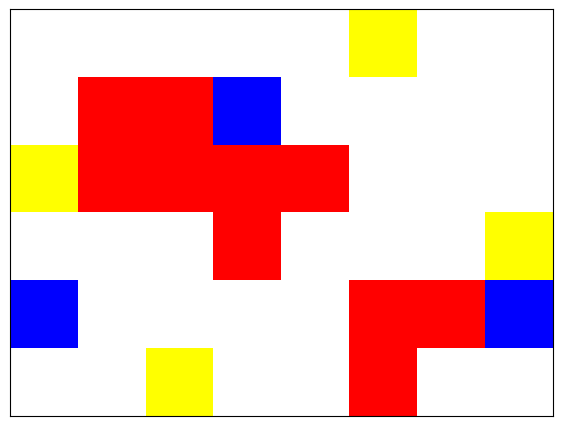

In [6]:

WALLS=  [
"1100 1000 1001 1100 1001 1100 1000 1001",
"0100 0000 0011 0100 0011 0110 0010 0011",
"0100 0001 1100 1000 1000 1001 1100 1001",
"0100 0011 0110 0010 0010 0011 0110 0011",
"1100 1000 1000 1000 1001 1100 1001 1101",
"0110 0010 0010 0010 0011 0110 0011 0111"]

IPOINTS = {(2,4):True,(5,1):False,(5,8):True,}
PLAYERS= 6
STEPS= 20
DOORS= [
    "1 3 1 4",
    "2 5 2 6",
    "2 8 3 8",
    "3 2 3 3",
    "4 4 5 4",
    "4 6 4 7",
    "6 5 6 6",
    "6 7 6 8"
    ]
FIRE= [
    "2 2",
    "2 3",
    "3 2",
    "3 3",
    "3 4",
    "3 5",
    "4 4",
    "5 6",
    "5 7",
    "6 6"
    ]
ENTRY= [
    "1 6",
    "3 1",
    "4 8",
    "6 3"
]
DOORS_DICT = {
    (y -1, x-1): False
    for door in DOORS
    for x1, y1, x2, y2 in [map(int, door.split())]
    for x in range(min(x1, x2), max(x1, x2) + 1)
    for y in range(min(y1, y2), max(y1, y2) + 1)
}

model = GhostModel(PLAYERS, IPOINTS, WALLS, DOORS_DICT, FIRE, ENTRY)
for i in range(STEPS):
    model.step()

all_grid = model.datacollector.get_model_vars_dataframe()


fig, axis = plt.subplots(figsize=(7, 7))
axis.set_xticks([])
axis.set_yticks([])

custom_cmap = ListedColormap(['white', 'grey', 'red', 'yellow', "blue"])
patch = plt.imshow(all_grid.iloc[0,0], cmap=custom_cmap)
borders = []

action_history_data = model.datacollector.get_agent_vars_dataframe()
#print(action_history_data)
def animate(i):
    grid_data = all_grid.iloc[i, 0]
    patch.set_data(grid_data)
action_history_data.to_csv("action_history.txt", index=False)
all_grid.to_csv("grid.txt", index=False)
anim= animation.FuncAnimation(fig, animate, frames=STEPS)
anim

In [10]:
modelPost = GhostModel(PLAYERS, IPOINTS, WALLS, DOORS_DICT, FIRE, ENTRY)

def get_and_clean_data_for_step(data_collector, step):
    # Obtener DataFrames completos
    model_df = data_collector.get_model_vars_dataframe()
    agent_df = data_collector.get_agent_vars_dataframe()

    # Filtrar datos para el paso específico
    model_step_df = model_df[model_df.index == step]
    agent_step_df = agent_df[agent_df.index.get_level_values(0) == step]

    # Convertir DataFrames a JSON
    model_json = model_step_df.to_json()
    agent_json = agent_step_df.to_json()
    
    return model_json, agent_json

class Server(BaseHTTPRequestHandler):
    def _set_response(self):
        self.send_response(200)
        self.send_header('Content-type', 'text/html')
        self.end_headers()
        
    def do_GET(self):
        self._set_response()
        self.wfile.write("GET request for {}".format(self.path).encode('utf-8')) #revisar

    def do_POST(self):
        modelPost.step()
        step= modelPost.schedule.steps -1
        infoGrid, infoAgentes = get_and_clean_data_for_step(modelPost.datacollector, step)
        #infoAgentes = modelPost.datacollector.get_agent_vars_dataframe().to_json()
        #infoGrid = modelPost.datacollector.get_model_vars_dataframe().to_json()

        #infoAgentes, infoGrid = modelPost.collect_data_current_step()
        

        # Enviar la información del paso actual
        self._set_response()
        self.wfile.write("{}\n{}".format(infoAgentes, infoGrid).encode('utf-8'))
def run(server_class=HTTPServer, handler_class=Server, port=8585):
    logging.basicConfig(level=logging.INFO)
    server_address = ('', port)
    httpd = server_class(server_address, handler_class)
    logging.info("Starting httpd...\n") # HTTPD is HTTP Daemon!
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:   # CTRL+C stops the server
        pass
    httpd.server_close()
    logging.info("Stopping httpd...\n")

if __name__ == '__main__':
    from sys import argv
    #if len(argv) == 2:
        #print(argv)
        #run(port=int(argv[1]))
    #else:
    run()

INFO:root:Starting httpd...

INFO:root:Stopping httpd...

